In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset

/home/thyme/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
T = 1000
time = torch.arange(1, T+1, dtype=torch.float32)
x = torch.sin(0.01*time) + torch.normal(0, 0.2, (T,))

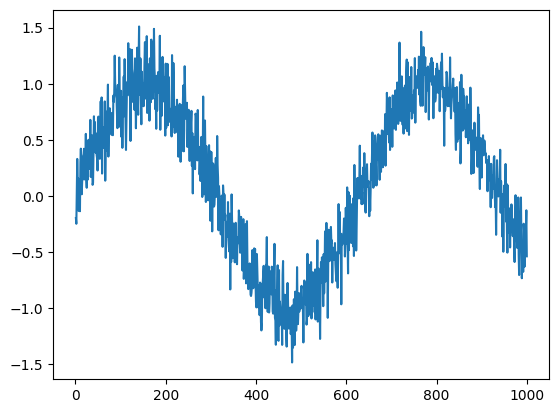

In [3]:
plt.plot(time, x)
plt.show()
plt.close()

In [4]:
class Net(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.net = nn.Sequential(nn.Linear(tau, 10), nn.ReLU(), nn.Linear(10, 1))
    def forward(self, input):
        return self.net(input)

In [5]:
tau = 4
lr = 1e-3
net = Net().cuda()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)
criterion = nn.MSELoss()

构造数据集

In [6]:
feat = torch.zeros((T-tau, tau))
label = x[tau:]
for i in range(tau):
    feat[:, i] = x[i:T-tau+i]

In [7]:
class myData(Dataset):
    def __init__(self, feat, label, train = True):
        super().__init__()
        self.train = train
        if train:
            self.feat = feat[:600]
            self.label = label[:600]
        else:
            self.feat = feat[600:]
            self.label = label[600:]
    def __getitem__(self, index):
        return self.feat[index], self.label[index]
    def __len__(self):
        return len(self.label)

In [8]:
train_data = myData(feat, label, True)
validate_data = myData(feat, label, False)

In [9]:
train_loader = DataLoader(train_data, 32, shuffle=True, num_workers=2)
validate_loader = DataLoader(validate_data, 32, shuffle=False, num_workers=2)

In [10]:
n_epoch = 15
for epoch in range(n_epoch):
    net.train()
    for X, y in train_loader:
        X = X.to('cuda')
        y = y.to('cuda').view(-1,)
        pred = net(X).view((-1,))
        loss = criterion(pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        print(f'\rEpoch:{epoch+1} loss:{loss.item():>.6f}', end='')
    print('')

Epoch:1 loss:0.251041
Epoch:2 loss:0.187461
Epoch:3 loss:0.187178
Epoch:4 loss:0.140561
Epoch:5 loss:0.104651
Epoch:6 loss:0.073928
Epoch:7 loss:0.045574
Epoch:8 loss:0.041547
Epoch:9 loss:0.046971
Epoch:10 loss:0.033161
Epoch:11 loss:0.052284
Epoch:12 loss:0.041447
Epoch:13 loss:0.060565
Epoch:14 loss:0.067963
Epoch:15 loss:0.060115


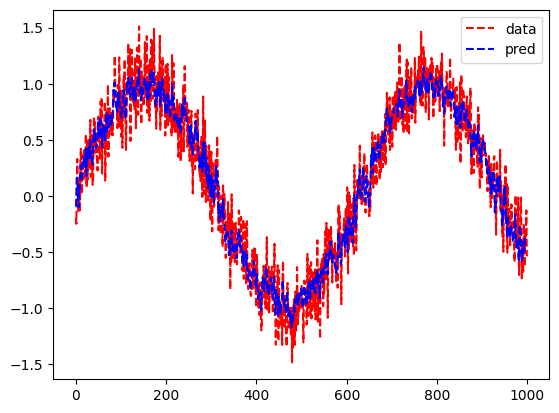

In [11]:
pred = net(feat.cuda()).view((-1,)).cpu()
plt.plot(range(len(x)), x, 'r--', label = 'data')
plt.plot(range(len(pred.detach())), pred.detach(), 'b--', label = 'pred')
plt.legend()
plt.show()
plt.close()

In [12]:
multistep_preds = torch.zeros(T)
multistep_preds[: 600 + tau] = x[: 600 + tau]
for i in range(600 + tau, T):
    multistep_preds[i] = net(
        multistep_preds[i - tau:i].reshape((1, -1)).cuda()).cpu()

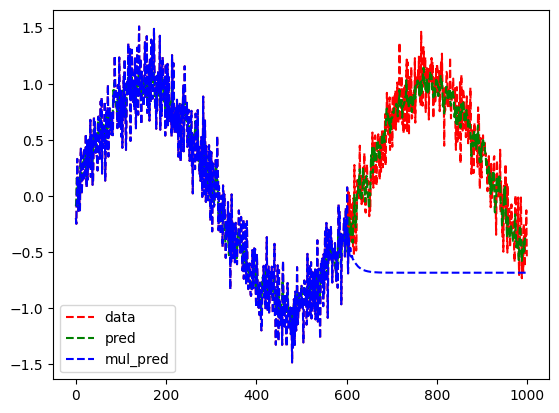

In [13]:
pred = net(feat.cuda()).view((-1,)).cpu()
plt.plot(range(len(x)), x, 'r--', label = 'data')
plt.plot(range(len(pred.detach())), pred.detach(), 'g--', label = 'pred')
plt.plot(range(len(multistep_preds.detach())), multistep_preds.detach(), 'b--', label = 'mul_pred')
plt.legend()
plt.show()
plt.close()